The aim of the project is to fine tune a large language model for HDL(hardware description language) generation and summarization

###Data Pre-Processing

In [5]:
import pandas as pd
import pyarrow.parquet as pq
import torch
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path = '/content/drive/MyDrive/ai-hdlcoder-dataset-part000000000000.parquet'

df = pq.read_table(source = dataset_path).to_pandas()

In [ ]:
df.head()

,repo_name,path,copies,size,content,license
0,malkadi/FGPU,RTL/floating_point/fmul.vhd,1,10488,"-- (c) Copyright 1995-2016 Xilinx, Inc. All ri...",gpl-3.0
1,malkadi/FGPU,bitstreams/settings_and_utilization/V2_4CUs_fl...,1,23540,-- libraries ---------------------------------...,gpl-3.0
2,Kinxil/VHDL_Projects,Mandelbrot/cpt_iter.vhd,1,884,\nlibrary IEEE;\nuse IEEE.STD_LOGIC_1164.ALL;\...,gpl-3.0
3,malkadi/FGPU,bitstreams/settings_and_utilization/V2_8CUs_fa...,1,24067,-- libraries ---------------------------------...,gpl-3.0
4,malkadi/FGPU,RTL/CU_instruction_dispatcher.vhd,1,10173,-- libraries ---------------------------------...,gpl-3.0


This is the dataset that we shall use to fine tune. The dataset contains VHDL codes scrapped from github. These code files will help the model learn the grammer of the VHDL language, nut in order for it to be able to genarate or summarize VHDL code, we have to include code summary and peoblem statements using which a compenent hardware designer would write the same HDL code. We shall take help from GPT-3.5 to do that!

In [ ]:
len(df)

53667

In [ ]:
content = []
start = ['LIBRARY IEEE', 'Library IEEE','Library Ieee', 'library ieee', 'library Ieee', 'library IEEE']
for i,string in enumerate(df['content']):
  print(i)
  content.append(string)
  for j in range(len(str(string))):
    if str(string)[j:j+12] in start:
      content.pop()
      content.append(string[j:])
      break
df['trimmed'] = content

In [ ]:
for i,string in enumerate(df['content']):
  for j in range(len(str(string))):
    if str(string)[j:j+12] in start:
      df['trimmed'][0] = string[j:]
      break
  if i==1:
    break

In [ ]:
df.to_csv('/content/drive/MyDrive/LLM_project/initial_df.csv')

In [ ]:
chars = []
words = []
for i,string in enumerate(df['trimmed']):
  a = str(string).split()
  words.append(len(a))

for num in df['size']:
  chars.append(int(str(num)))

0.10460829358480879
0.0013090163279222086


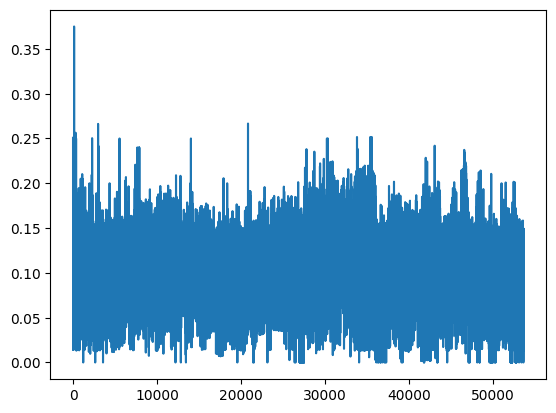

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(range(len(df)), np.array(words)/np.array(chars))
print(np.mean(np.array(words)/np.array(chars)))
print(np.var(np.array(words)/np.array(chars)))

In [ ]:
count_5000 = 0
count_10000 = 0
count_2000 = 0
count_1000 = 0
for string in df['trimmed']:
  if len(str(string)) <= 1000 and str(string)[:12] in start:
    count_1000 += 1
  elif len(str(string)) <= 2000 and str(string)[:12] in start:
    count_2000 += 1
  elif len(str(string)) <= 5000 and str(string)[:12] in start:
    count_5000 += 1
  elif len(str(string)) <= 1000 and str(string)[:12] in start:
    count_10000 += 1
print(count_1000, count_2000, count_5000, count_10000)

7664 5636 8189 0


In [ ]:
#trimming comments and other details from the beginning of the code
df_1000 = pd.DataFrame(columns = df.columns)
start = ['LIBRARY IEEE', 'Library IEEE','Library Ieee', 'library ieee', 'library Ieee', 'library IEEE']
for i,string in enumerate(df['trimmed']):
  if len(str(string)) <= 1000 and str(string)[:12] in start:
    df_1000.loc[len(df_1000.index)] = list(df.iloc[i])

In [ ]:
df_1000['gpt-3.5'] = ['hello']*len(df_1000.index)
df_1000.head()

,repo_name,path,copies,size,content,license,trimmed,gpt-3.5
0,Kinxil/VHDL_Projects,Mandelbrot/cpt_iter.vhd,1,884,\nlibrary IEEE;\nuse IEEE.STD_LOGIC_1164.ALL;\...,gpl-3.0,library IEEE;\nuse IEEE.STD_LOGIC_1164.ALL;\n\...,hello
1,joalcava/sparcv8-monocicle,MuxNextRD.vhd,1,444,library IEEE;\nuse IEEE.STD_LOGIC_1164.ALL;\n\...,gpl-3.0,library IEEE;\nuse IEEE.STD_LOGIC_1164.ALL;\n\...,hello
2,joalcava/sparcv8-monocicle,DM.vhd,1,987,library IEEE;\nuse IEEE.STD_LOGIC_1164.ALL;\nu...,gpl-3.0,library IEEE;\nuse IEEE.STD_LOGIC_1164.ALL;\nu...,hello
3,chrreisinger/OpenVC,document/Masterarbeit/src/math_complex.vhd,1,691,library ieee;\n\npackage math_complex is\n ty...,gpl-3.0,library ieee;\n\npackage math_complex is\n ty...,hello
4,jpidancet/mips,rtl/cpu_fetch.vhd,1,905,library ieee;\nuse ieee.std_logic_1164.ALL;\nu...,isc,library ieee;\nuse ieee.std_logic_1164.ALL;\nu...,hello


###GPT-3.5 API setup and HDL code summary generation

In [2]:
df_1000 = pd.read_csv('/content/drive/MyDrive/LLM_project/df_1000.csv')

In [ ]:
!pip install -q openai
import time
import openai

In [ ]:
f = open('/content/drive/MyDrive/LLM_project/api_key.txt', 'r')
api_key = str(f.readlines()[3])[:-1] #9xxxxxx333

In [ ]:
openai.api_key = api_key

In [ ]:
precursur = ('can you give a statement of about 100 words taking which a competent programmer would write the below HDL code.\n')

n_prompts = 2400
start_from = 2400
for i in range(start_from, n_prompts):
  t = time.time()
  messages = [{'role': 'system', 'content': 'You are hardware designer briefly explaining the HDL code given to you'},]

  prompt = str(df_1000['trimmed'][i])
  messages.append({'role': 'user', 'content': prompt})
  chat = openai.ChatCompletion.create(
              model="gpt-3.5-turbo", messages=messages)

  reply = chat.choices[0].message.content
  df_1000['gpt-3.5'][i] = reply

  time.sleep(10)
  print(i/100)
  df_1000.to_csv('/content/drive/MyDrive/LLM_project/df_1000.csv')

We setup GPT-3.5 api and generated and filled the required fields in our dataset

###Fine tuning GPT-2

In [6]:
!pip install -q transformers datasets evaluate
from huggingface_hub import notebook_login
notebook_login()

In [10]:
code_gen = 1100
code_summarize = 1300

dset = []

for i in range(len(df_1000)):
  if i < code_gen:
    dset.append(df_1000['gpt-3.5'][i] + '\n' + df_1000['trimmed'][i])
  elif i < code_gen + code_summarize:
    dset.append('summarize the below code\n' + df_1000['trimmed'][i] + '\n' + df_1000['gpt-3.5'][i])
  else:
    dset.append('complete the below code\n' + df_1000['trimmed'][i])

df_final = pd.DataFrame({'text':dset})
df_final.head()
df_final.to_csv('/content/drive/MyDrive/LLM_project/df_final.csv')

In [3]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('gpt2')

In [4]:
from datasets import load_dataset, Dataset
df_final = pd.read_csv('/content/drive/MyDrive/LLM_project/df_final.csv')
dataset = Dataset.from_pandas(df_final)
dataset = dataset.train_test_split(test_size=0.2)

def tokenize(input):
  return tokenizer(input['text'], truncation=True)

tokenized_dataset = dataset.map(tokenize, batched=True)

Map:   0%|          | 0/6131 [00:00<?, ? examples/s]

Map:   0%|          | 0/1533 [00:00<?, ? examples/s]

In [5]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'text', 'input_ids', 'attention_mask'],
        num_rows: 6131
    })
    test: Dataset({
        features: ['Unnamed: 0', 'text', 'input_ids', 'attention_mask'],
        num_rows: 1533
    })
})

In [6]:
block_size = 128
def group_texts(inputs):
    #concatenated_inputs = {k: sum(inputs[k], []) for k in inputs.keys()}
    total_length = len(inputs[list(inputs.keys())[0]])
    if total_length >= block_size:
        total_length = (total_length // block_size) * block_size
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in inputs.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

lm_dataset = tokenized_dataset.map(group_texts, batched=True)

Map:   0%|          | 0/6131 [00:00<?, ? examples/s]

Map:   0%|          | 0/1533 [00:00<?, ? examples/s]

In [7]:
lm_dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 43
    })
    test: Dataset({
        features: ['Unnamed: 0', 'text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 11
    })
})

In [8]:
from transformers import DataCollatorForLanguageModeling

tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

Training the model

In [9]:
!pip install -q -U accelerate
!pip install -q -U transformers

In [10]:
from transformers import AutoModelForCausalLM, TrainingArguments, Trainer
model = AutoModelForCausalLM.from_pretrained('gpt2')

training_args = TrainingArguments(output_dir='/content/drive/MyDrive/LLM_project/gpt2_hdl',
                                  per_device_train_batch_size=2,
                                  evaluation_strategy="epoch",
                                  learning_rate=2e-5,
                                  weight_decay=0.01,
                                  push_to_hub=True,
                                  )

trainer = Trainer(model=model,
                  args=training_args,
                  train_dataset=tokenized_dataset['train'],
                  eval_dataset=tokenized_dataset['test'],
                  data_collator=data_collator,
                  )

/content/drive/MyDrive/LLM_project/gpt2_hdl is already a clone of https://huggingface.co/myn11/gpt2_hdl. Make sure you pull the latest changes with `repo.git_pull()`.


In [11]:
gpu_device = torch.device("cuda:0")
current_memory_usage = torch.cuda.memory_allocated(device=gpu_device)
max_memory_capacity = torch.cuda.max_memory_allocated(device=gpu_device)

print(current_memory_usage, max_memory_capacity)

511148032 511148032


In [12]:
torch.cuda.empty_cache()
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,0.982200,0.913574
2,0.886600,0.837943
3,0.817100,0.816834


TrainOutput(global_step=9198, training_loss=0.9767863951083965, metrics={'train_runtime': 3576.5038, 'train_samples_per_second': 5.143, 'train_steps_per_second': 2.572, 'total_flos': 4389900065280000.0, 'train_loss': 0.9767863951083965, 'epoch': 3.0})

In [13]:
import math
eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

Perplexity: 2.26


In [ ]:
trainer.push_to_hub()

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Testing the model

In [ ]:
prompt = 'library IEEE;\nuse IEEE.STD_LOGIC_1164.ALL;\nentity XOR_BitABit is\nPort ( A : in  STD_LOGIC_VECTOR (3 downto 0);\nB : in  STD_LOGIC_VECTOR (3 downto 0);\nZ : out  STD_LOGIC_VECTOR (3 downto 0));\nend XOR_BitABit;\narchitecture Behavioral of XOR_BitABit is\nsignal Zout : STD_LOGIC_VECTOR(3 downto 0);\nbegin\nZout(0) <= A(0) XOR B(0);\nZout(1) <= A(1) XOR B(1);\nZout(2) <= A(2) XOR B(2);\nZout(3) <= A(3) XOR B(3);\nZ <= Zout;\nend Behavioral;'

from transformers import AutoModelForCausalLM, TrainingArguments, Trainer, pipeline, AutoTokenizer
model = AutoModelForCausalLM.from_pretrained('/content/drive/MyDrive/LLM_project/gpt2_hdl/')
tokenizer = AutoTokenizer.from_pretrained('gpt2')
inputs = tokenizer(prompt, return_tensors='pt').input_ids
output = model.generate(inputs, max_length = 500)

In [16]:
tokenizer.batch_decode(output, skip_special_tokens=True)

['library IEEE;\nuse IEEE.STD_LOGIC_1164.ALL;\nentity XOR_BitABit is\nPort ( A : in  STD_LOGIC_VECTOR (3 downto 0);\nB : in  STD_LOGIC_VECTOR (3 downto 0);\nZ : out  STD_LOGIC_VECTOR (3 downto 0));\nend XOR_BitABit;\narchitecture Behavioral of XOR_BitABit is\nsignal Zout : STD_LOGIC_VECTOR(3 downto 0);\nbegin\nZout(0) <= A(0) XOR B(0);\nZout(1) <= A(1) XOR B(1);\nZout(2) <= A(2) XOR B(2);\nZout(3) <= A(3) XOR B(3);\nZ <= Zout;\nend Behavioral;\n\nThe given HDL code is for a hardware design that implements a bit-wise AND operation between two input vectors. \n\nThe entity declaration defines the inputs and outputs of the design. It has two ports: A and B, which are input vectors of type STD_LOGIC_VECTOR. \n\nThe architecture declaration defines the behavior of the design. It uses the IEEE.STD_LOGIC_1164 library for standard logic operations. \n\nThe architecture section defines the behavior of the design. It uses the behavioral package to implement the bit-wise AND operation between two

In [18]:
prompt = 'Implement a full adder circuit in HDL. A and B are the inputs, Cin in the input carray and S and Cout are output sum and carry respectively'
inputs = tokenizer(prompt, return_tensors='pt').input_ids
output = model.generate(inputs, max_length = 500)
print('\n\n')
tokenizer.batch_decode(output, skip_special_tokens=True)

["Implement a full adder circuit in HDL. A and B are the inputs, Cin in the input carray and S and Cout are output sum and carry respectively.\n\nThe circuit should have the following inputs and outputs:\n\nInputs:\n- Cin: a single bit input representing the input signal\n- S: a single bit input representing the input signal\n- Cout: a single bit input representing the output signal\n\nOutputs:\n- Cout: a single bit output representing the output signal\n\nThe circuit should have the following outputs:\n- Cout: a single bit output representing the output signal\n\nThe circuit should be implemented using VHDL.\nlibrary ieee;\nuse ieee.std_logic_1164.all;\n\nentity adder is\n\tport (\n\t\tCin : in std_logic_vector(3 downto 0);\n\t\tS : in std_logic_vector(3 downto 0);\n\t\tCout : out std_logic_vector(3 downto 0)\n\t);\nend adder;\n\narchitecture rtl of adder is\nbegin\n\tCout <= Cin when S = '1' else Cout;\n\tCout <= Cin when S = '0' else Cout;\nend rtl;\n\nThe given HDL code is for a fu

In [19]:
prompt = 'library IEEE;\nuse IEEE.STD_LOGIC_1164.ALL;\nentity XOR_BitABit is\nPort ( A : in  STD_LOGIC_VECTOR (3'
inputs = tokenizer(prompt, return_tensors='pt').input_ids
output = model.generate(inputs, max_length = 200)
tokenizer.batch_decode(output, skip_special_tokens=True)

['library IEEE;\nuse IEEE.STD_LOGIC_1164.ALL;\nentity XOR_BitABit is\nPort ( A : in  STD_LOGIC_VECTOR (3 downto 0);\n\t\t\tB : in  STD_LOGIC_VECTOR (3 downto 0);\n\t\t\tC : in  STD_LOGIC_VECTOR (3 downto 0);\n\t\t\tD : in  STD_LOGIC_VECTOR (3 downto 0);\n\t\t\tE : in  STD_LOGIC_VECTOR (3 downto 0);\n\t\t\tF : in  STD_LOGIC_VECTOR (3 downto 0);\n\t\t\tG : in  STD_LOGIC_VECTOR (3 downto 0);\n\t\t\tH : in  STD_LOGIC_VECTOR (3 downto 0']

The model is repeating the same thing, Let's try changin top_k and top_p

In [23]:
prompt = 'library IEEE;\nuse IEEE.STD_LOGIC_1164.ALL;\nentity XOR_BitABit is\nPort ( A : in  STD_LOGIC_VECTOR (3'
inputs = tokenizer(prompt, return_tensors='pt').input_ids
output = model.generate(inputs, max_length = 200, do_sample=True, top_k = 0, top_p = 0.95)
tokenizer.batch_decode(output, skip_special_tokens=True)

['library IEEE;\nuse IEEE.STD_LOGIC_1164.ALL;\nentity XOR_BitABit is\nPort ( A : in  STD_LOGIC_VECTOR (3 downto 0);\n\t\tB : in  STD_LOGIC_VECTOR (3 downto 0);\n\t\tH : out STD_LOGIC_VECTOR (2 downto 0);\n\t\tR : out STD_LOGIC_VECTOR (2 downto 0));\nend XOR_BitABit;\n\narchitecture Behavioral of XOR_BitABit is\nbegin\n\n\tR <= A;\n\tH <= b;\n\nend Behavioral;\n\n\nThis HDL code represents an asynchronous bit-bit multiplication operation. \n\nThe code describes a simple operation that is implemented using the entity declaration and port declaration. The entity declaration defines the inputs and outputs of the operation. \n\nInside']

In [29]:
prompt = 'summarize this library IEEE; use IEEE.STD_LOGIC_1164.ALL; use IEEE.NUMERIC_STD.ALL; use work.randgen_package.all; entity chaoticMap is Port ( clk : in std_logic; reset : in std_logic; output : out std_logic); end chaoticMap; architecture Behavioral of chaoticMap is -- Supposing 2 integer bits and two\'s complement, the constants -- correspond to zero, one and minus one values constant zero : signed(N_BIT-1 downto 0) := (others => \'0\'); constant one : signed(N_BIT-1 downto 0) := (N_BIT-2 => \'1\', others => \'0\'); constant minusone : signed(N_BIT-1 downto 0) := (N_BIT-1 => \'1\', N_BIT-2 => \'1\', others => \'0\'); -- Stores the current state signal reg : signed(N_BIT-1 downto 0); begin -- update map proc_map: process(clk,reset) begin if reset = \'0\' then if rising_edge(clk) then -- 1.875 * reg = (2*reg) - (reg/8) = (reg<<1) - (reg>>3) if (reg < zero) then -- reg = 1.875 * reg + 1 reg <= (( reg(N_BIT-2 downto 0) & "0" ) - ( "111" & reg(N_BIT-1 downto 3) )) + one; else -- reg = 1.875 * reg - 1 reg <= (( reg(N_BIT-2 downto 0)&\'0\' ) - ( "000" & reg(N_BIT-1 downto 3) )) + minusone; end if; end if; else -- init reg <= X0; end if; end process; output <= reg(N_BIT-1); end Behavioral;'
inputs = tokenizer(prompt, return_tensors='pt').input_ids
output = model.generate(inputs, max_length = 1000, do_sample=True, top_k = 0, top_p = 0.95, temperature = 0.9)
tokenizer.batch_decode(output, skip_special_tokens=True)

['summarize this library IEEE; use IEEE.STD_LOGIC_1164.ALL; use IEEE.NUMERIC_STD.ALL; use work.randgen_package.all; entity chaoticMap is Port ( clk : in std_logic; reset : in std_logic; output : out std_logic); end chaoticMap; architecture Behavioral of chaoticMap is -- Supposing 2 integer bits and two\'s complement, the constants -- correspond to zero, one and minus one values constant zero : signed(N_BIT-1 downto 0) := (others => \'0\'); constant one : signed(N_BIT-1 downto 0) := (N_BIT-2 => \'1\', others => \'0\'); constant minusone : signed(N_BIT-1 downto 0) := (N_BIT-1 => \'1\', N_BIT-2 => \'1\', others => \'0\'); -- Stores the current state signal reg : signed(N_BIT-1 downto 0); begin -- update map proc_map: process(clk,reset) begin if reset = \'0\' then if rising_edge(clk) then -- 1.875 * reg = (2*reg) - (reg/8) = (reg<<1) - (reg>>3) if (reg < zero) then -- reg = 1.875 * reg + 1 reg <= (( reg(N_BIT-2 downto 0) & "0" ) - ( "111" & reg(N_BIT-1 downto 3) )) + one; else -- reg = 1.8

In [31]:
prompt = 'summarize the hdl code \n library IEEE; use IEEE.STD_LOGIC_1164.ALL; use IEEE.STD_LOGIC_ARITH.ALL; use IEEE.STD_LOGIC_UNSIGNED.ALL;\nentity ROM is generic ( DATA_WIDTH : positive := 8; -- Width of data bus ADDR_WIDTH : positive := 10; -- Width of address bus FILE_NAME : string := "data.txt" -- External initialization file name ); port ( address : in std_logic_vector(ADDR_WIDTH - 1 downto 0); data_out : out std_logic_vector(DATA_WIDTH - 1 downto 0) ); end ROM;\narchitecture Behavioral of ROM is type memory_array is array (0 to 2**ADDR_WIDTH - 1) of std_logic_vector(DATA_WIDTH - 1 downto 0); signal memory : memory_array; \n procedure initialize_memory(file_name : string) is file data_file : text; variable line_buf : line; variable data_value : std_logic_vector(DATA_WIDTH - 1 downto 0); begin file_open(data_file, file_name, read_mode); for i in 0 to memory high loop readline(data_file, line_buf); read(line_buf, data_value); memory(i) <= data_value; end loop; file_close(data_file); end initialize_memory; \n begin initialize_memory(FILE_NAME); \n process(address) begin data_out <= memory(to_integer(unsigned(address))); end process; end Behavioral;'
inputs = tokenizer(prompt, return_tensors='pt').input_ids
output = model.generate(inputs, max_length = 1000, do_sample=True, top_k = 0, top_p = 0.95, temperature = 0.9)
tokenizer.batch_decode(output, skip_special_tokens=True)

['summarize the hdl code \n library IEEE; use IEEE.STD_LOGIC_1164.ALL; use IEEE.STD_LOGIC_ARITH.ALL; use IEEE.STD_LOGIC_UNSIGNED.ALL;\nentity ROM is generic ( DATA_WIDTH : positive := 8; -- Width of data bus ADDR_WIDTH : positive := 10; -- Width of address bus FILE_NAME : string := "data.txt" -- External initialization file name ); port ( address : in std_logic_vector(ADDR_WIDTH - 1 downto 0); data_out : out std_logic_vector(DATA_WIDTH - 1 downto 0) ); end ROM;\narchitecture Behavioral of ROM is type memory_array is array (0 to 2**ADDR_WIDTH - 1) of std_logic_vector(DATA_WIDTH - 1 downto 0); signal memory : memory_array; \n procedure initialize_memory(file_name : string) is file data_file : text; variable line_buf : line; variable data_value : std_logic_vector(DATA_WIDTH - 1 downto 0); begin file_open(data_file, file_name, read_mode); for i in 0 to memory high loop readline(data_file, line_buf); read(line_buf, data_value); memory(i) <= data_value; end loop; file_close(data_file); end i

In [35]:
model.push_to_hub('gpt2_hdl')
tokenizer.push_to_hub('gpt2_hdl')

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/myn11/gpt2_hdl/commit/893beafc24722ed7e2c732b1791adc13c2bddf2a', commit_message='Upload tokenizer', commit_description='', oid='893beafc24722ed7e2c732b1791adc13c2bddf2a', pr_url=None, pr_revision=None, pr_num=None)

###Gradio Webapp

In [ ]:
import pandas as pd
import torch
from google.colab import drive
drive.mount('/content/drive')
!pip install transformers

In [15]:
!pip install -q gradio
import gradio as gr
from transformers import AutoModelForCausalLM, TrainingArguments, Trainer, pipeline, AutoTokenizer
model = AutoModelForCausalLM.from_pretrained('myn11/gpt2_hdl').to('cuda')
tokenizer = AutoTokenizer.from_pretrained('myn11/gpt2_hdl')

In [24]:
examples = [
  ['summarise the code library IEEE;use IEEE.std_logic_1164.all;entity Top is port (dips_i :  in std_logic_vector(3 downto 0);pbs_i  :  in std_logic;leds_o : out std_logic_vector(3 downto 0));end entity Top;architecture RTL of Top is begin leds_o  <= dips_i when pbs_i="0" else (others => "1"); end architecture RTL;'],
  ['Explain the code library ieee;use ieee.std_logic_1164.all;entity test is port(clk : in std_logic;d : in std_logic ;q :out std_logic );end test;architecture rtl of test is begin process (clk) begin if rising_edge(clk) then q <= d; end if; end; end rtl;'],
  ['Write a VHDL code for a read-only memory (ROM) module that takes an external data initialization file, and is parameterized by the data width, address width, and file name. The module should have an address input and a data output. It should read data from the file and provide the corresponding data output based on the given address.']
]

title = "GPT2 fine tuned for HDL"

def process_input(text):
 input = tokenizer(text, truncation=True, return_tensors='pt').input_ids.to('cuda')
 output = model.generate(input, max_length=1000, do_sample=True, top_k=50, top_p=0.92)
 return tokenizer.batch_decode(output, skip_special_tokens=True)

model_gui = gr.Interface(
  process_input,
  gr.Textbox(lines=3,label="Input"),
  gr.Textbox(lines=3, label="GPT2_HDL"),
  title=title,
  examples=examples
)
model_gui.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://914623a42bfd061ca1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
